In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install netCDF4
!pip install cartopy

In [4]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import glob

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import cartopy.crs as ccrs

from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from tabulate import tabulate
from pathlib import Path

data_path = "drive/MyDrive/ML/Data/"
!python --version


Python 3.10.12


In [4]:
ds = xr.open_dataset(data_path + "train/data-2004-08-19-01-1_0.nc")


In [5]:
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2004-08-19-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...

In [6]:
 ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2004-08-19-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...

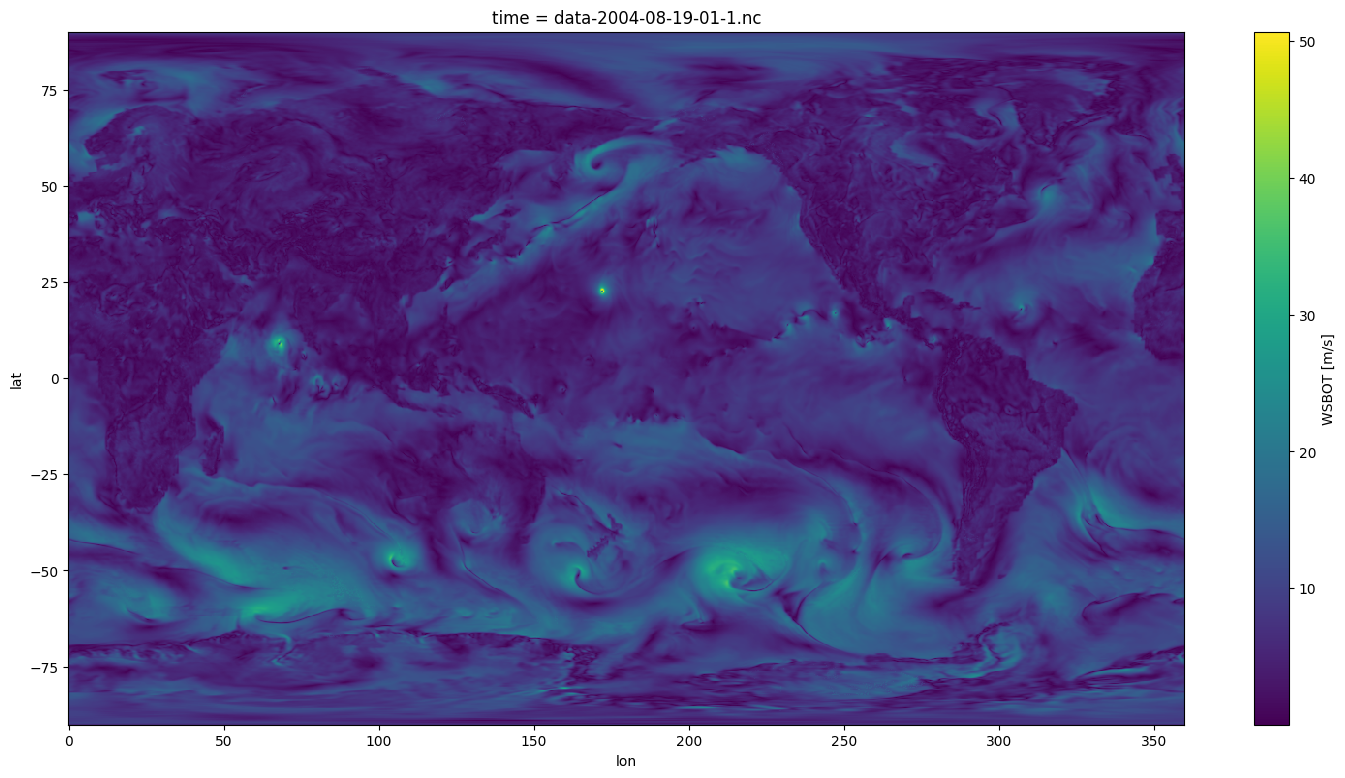

In [7]:
ubot = ds["UBOT"]
vbot = ds["VBOT"]
ds["WSBOT"] = np.sqrt(ubot**2 + vbot**2)
ds.WSBOT.attrs['description'] = 'wind speed at lowest level'
ds.WSBOT.attrs['units'] = 'm/s'

fig = plt.figure(figsize=(18,9))
ds.WSBOT[0,:,:].plot()

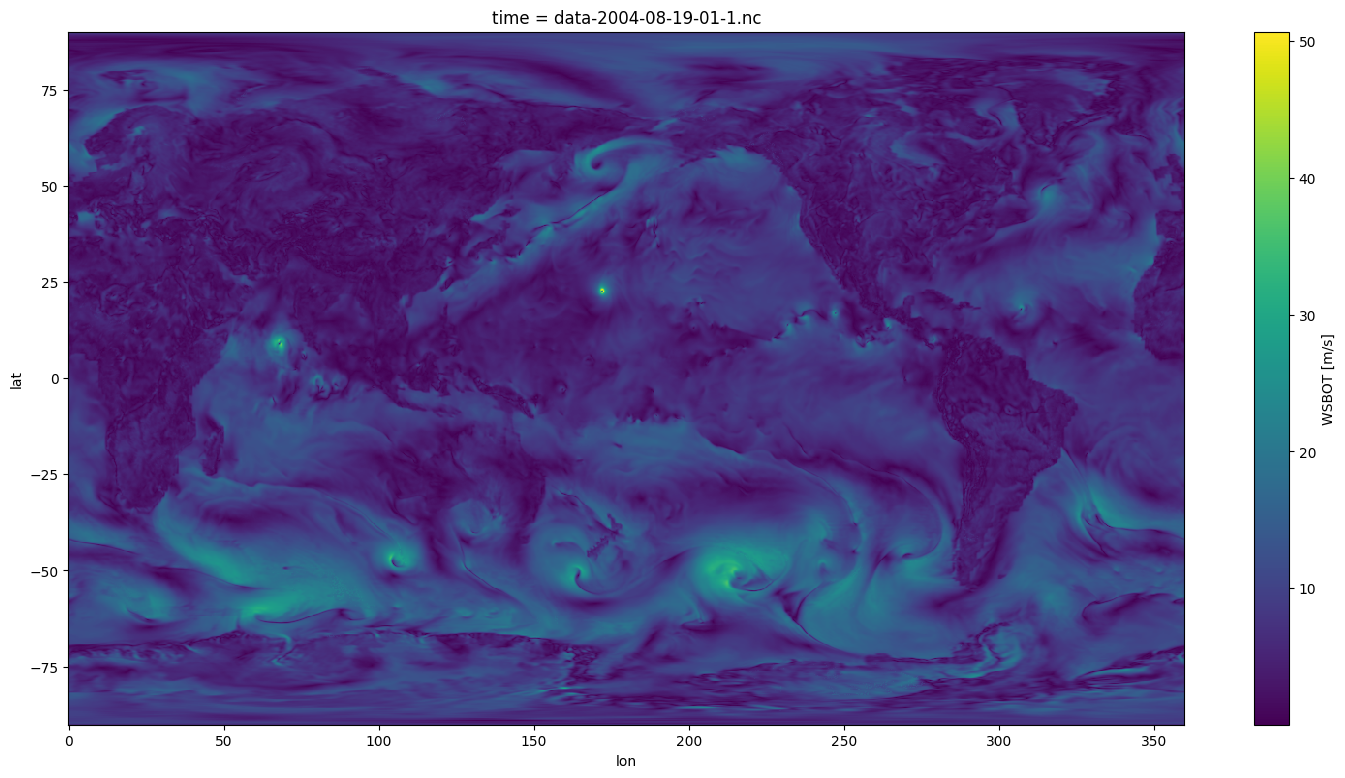

In [8]:
u850 = ds.U850
v850 = ds.U850
ds["WS850"] = np.sqrt(u850**2 + v850**2)
ds.WS850.attrs['description'] = 'wind speed at 850 hPa'
ds.WS850.attrs['units'] = 'm/s'

fig = plt.figure(figsize=(18,9))
ds.WSBOT[0,:,:].plot()

In [5]:
def velocity(u, v):

    wind_speed = np.sqrt(u**2 + v**2)
    return wind_speed


def vorticity(u, v):

    dv = v.differentiate("lon")
    cosTheta = np.cos(lat*(np.pi/180))

    u_cosTheta = u * cosTheta
    du = (1/(1e-3+cosTheta)) * u_cosTheta.differentiate("lat")

    zeta = dv - du
    return zeta.astype(np.float32)


In [6]:
origin_folder = 'train/'
dest_folder = 'Engineered/train/'
for idx, filename_in in enumerate(glob.glob(data_path + origin_folder + '*.nc')):

    ds = xr.open_dataset(filename_in)

    file = Path(filename_in)
    print(str(idx)+". Processing: "+file.stem+file.suffix)

    lat = ds["lat"]
    lon = ds["lon"]

    # Wind speed at 850 hPa
    ds["WS850"] = velocity(ds.U850, ds.V850)
    ds.WS850.attrs['description'] = 'wind speed at 850 mbar pressure surface'
    ds.WS850.attrs['units'] = 'm/s'

    # Wind speed at lower level
    ds["WSBOT"] = velocity(ds.UBOT, ds.VBOT)
    ds.WSBOT.attrs['description'] = 'lowest level wind speed'
    ds.WSBOT.attrs['units'] = 'm/s'

    # Wind vorticity at 850 hPa
    ds["VRT850"] = vorticity(ds.U850[0,:,:], ds.V850[0,:,:]).astype(np.float32)
    ds.VRT850.attrs['description'] = 'wind vorticity at 850 mbar pressure surface'
    ds.VRT850.attrs['units'] = 's^-1'

    # Wind vorticity at 850 hPa
    ds["VRTBOT"] = vorticity(ds.UBOT[0,:,:], ds.VBOT[0,:,:]).astype(np.float32)
    ds.VRTBOT.attrs['description'] = 'lowest level wind vorticity'
    ds.VRTBOT.attrs['units'] = 's^-1'

    # Clean up sample
    ds = ds.drop_vars(['TREFHT', 'PS', 'QREFHT', 'T200', 'T500', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT'])

    # Save sample to new folder
    filename_out = data_path + dest_folder + file.stem + file.suffix
    print("Saving: "+filename_out+'\n')

    ds.to_netcdf(filename_out)

0. Processing: data-1996-06-09-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-06-09-01-1_0.nc

1. Processing: data-1996-07-11-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-07-11-01-1_0.nc

2. Processing: data-1996-07-18-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-07-18-01-1_0.nc

3. Processing: data-1996-07-18-01-1_2.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-07-18-01-1_2.nc

4. Processing: data-1996-09-01-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-09-01-01-1_0.nc

5. Processing: data-1996-09-01-01-1_1.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-09-01-01-1_1.nc

6. Processing: data-1996-09-12-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-09-12-01-1_0.nc

7. Processing: data-1996-09-26-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/train/data-1996-09-26-01-1_0.nc

8. Processing: data-1996-09-26-01-1_1.nc
Saving: drive/MyDrive/ML/Data/Engineere

In [9]:
origin_folder = 'test/'
dest_folder = 'Engineered/test/'
for idx, filename_in in enumerate(glob.glob(data_path + origin_folder + '*.nc')):

    ds = xr.open_dataset(filename_in)

    file = Path(filename_in)
    print(str(idx)+". Processing: "+file.stem+file.suffix)

    lat = ds["lat"]
    lon = ds["lon"]

    # Wind speed at 850 hPa
    ds["WS850"] = velocity(ds.U850, ds.V850)
    ds.WS850.attrs['description'] = 'wind speed at 850 mbar pressure surface'
    ds.WS850.attrs['units'] = 'm/s'

    # Wind speed at lower level
    ds["WSBOT"] = velocity(ds.UBOT, ds.VBOT)
    ds.WSBOT.attrs['description'] = 'lowest level wind speed'
    ds.WSBOT.attrs['units'] = 'm/s'

    # Wind vorticity at 850 hPa
    ds["VRT850"] = vorticity(ds.U850[0,:,:], ds.V850[0,:,:]).astype(np.float32)
    ds.VRT850.attrs['description'] = 'wind vorticity at 850 mbar pressure surface'
    ds.VRT850.attrs['units'] = 's^-1'

    # Wind vorticity at 850 hPa
    ds["VRTBOT"] = vorticity(ds.UBOT[0,:,:], ds.VBOT[0,:,:]).astype(np.float32)
    ds.VRTBOT.attrs['description'] = 'lowest level wind vorticity'
    ds.VRTBOT.attrs['units'] = 's^-1'

    # Clean up sample
    ds = ds.drop_vars(['TREFHT', 'PS', 'QREFHT', 'T200', 'T500', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT'])

    # Save sample to new folder
    filename_out = data_path + dest_folder + file.stem + file.suffix
    print("Saving: "+filename_out+'\n')

    ds.to_netcdf(filename_out)

0. Processing: data-2011-06-01-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-06-01-01-1_0.nc

1. Processing: data-2011-06-03-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-06-03-01-1_0.nc

2. Processing: data-2011-06-03-01-1_1.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-06-03-01-1_1.nc

3. Processing: data-2011-06-16-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-06-16-01-1_0.nc

4. Processing: data-2011-07-26-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-07-26-01-1_0.nc

5. Processing: data-2011-07-26-01-1_1.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-07-26-01-1_1.nc

6. Processing: data-2011-07-29-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-07-29-01-1_0.nc

7. Processing: data-2011-08-08-01-1_0.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/data-2011-08-08-01-1_0.nc

8. Processing: data-2011-08-08-01-1_1.nc
Saving: drive/MyDrive/ML/Data/Engineered/test/d

In [17]:
from math import pi
import pandas as pd

folder = 'Engineered/train/'
channels = ["TMQ", "U850", "V850", "UBOT", "VBOT", "PSL", "PRECT", "WS850", "WSBOT", "VRT850", "VRTBOT"]
pixels = ["LABELS:BG", "LABELS:TC", "LABELS:AR"]

col_names = []
for channel in channels:
  col_names += [channel+" Mean", channel+" Std Dev"]
col_names += pixels

df = pd.DataFrame(columns = col_names)

In [18]:
df

,TMQ Mean,TMQ Std Dev,U850 Mean,U850 Std Dev,V850 Mean,V850 Std Dev,UBOT Mean,UBOT Std Dev,VBOT Mean,VBOT Std Dev,...,WS850 Std Dev,WSBOT Mean,WSBOT Std Dev,VRT850 Mean,VRT850 Std Dev,VRTBOT Mean,VRTBOT Std Dev,LABELS:BG,LABELS:TC,LABELS:AR


In [20]:
for idx, filename in enumerate(glob.glob(data_path + folder + '*.nc')):

    ds = xr.open_dataset(filename)

    file = Path(filename)
    if idx%10 == 0:
      print(str(idx)+". Processing: "+file.stem+file.suffix)

    new_row = []

    for channel in channels:
     new_row = new_row + [ds[channel].mean().values.item(),\
                         ds[channel].std().values.item()]

    labels = ds.LABELS
    counts = [labels.where(labels==0).count().values.item(),
              labels.where(labels==1).count().values.item(),
              labels.where(labels==2).count().values.item()]
    new_row = new_row + counts

    df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))

    ds.close()

df

0. Processing: data-1996-06-09-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

10. Processing: data-1996-10-03-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

20. Processing: data-1997-08-14-01-1_3.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

30. Processing: data-1998-07-06-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

40. Processing: data-1998-08-27-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

50. Processing: data-1999-06-21-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

60. Processing: data-1999-08-22-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

70. Processing: data-2000-04-17-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

80. Processing: data-2000-06-25-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

90. Processing: data-2000-09-06-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

100. Processing: data-2000-09-06-01-1_11.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

110. Processing: data-2000-11-06-01-1_3.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

120. Processing: data-2000-12-20-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

130. Processing: data-2001-03-03-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

140. Processing: data-2001-03-24-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

150. Processing: data-2001-07-03-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

160. Processing: data-2001-07-18-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

170. Processing: data-2001-08-01-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

180. Processing: data-2001-09-19-01-1_3.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

190. Processing: data-2001-10-29-01-1_2.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

200. Processing: data-2001-12-07-01-1_7.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

210. Processing: data-2002-02-04-01-1_2.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

220. Processing: data-2002-04-25-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

230. Processing: data-2002-06-22-01-1_6.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

240. Processing: data-2002-08-04-01-1_3.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

250. Processing: data-2002-10-13-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

260. Processing: data-2002-11-17-01-1_3.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

270. Processing: data-2002-12-03-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

280. Processing: data-2003-07-24-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

290. Processing: data-2004-08-11-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

300. Processing: data-2004-10-03-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

310. Processing: data-2005-10-24-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

320. Processing: data-2006-09-14-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

330. Processing: data-2007-07-16-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

340. Processing: data-2007-10-09-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

350. Processing: data-2008-10-03-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

360. Processing: data-2009-08-02-01-1_0.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

370. Processing: data-2009-10-16-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

380. Processing: data-2010-08-30-01-1_3.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

390. Processing: data-2010-10-10-01-1_1.nc


<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))
<ipython-input-20-fed968a48a6b>:21: FutureWa

,TMQ Mean,TMQ Std Dev,U850 Mean,U850 Std Dev,V850 Mean,V850 Std Dev,UBOT Mean,UBOT Std Dev,VBOT Mean,VBOT Std Dev,...,WS850 Std Dev,WSBOT Mean,WSBOT Std Dev,VRT850 Mean,VRT850 Std Dev,VRTBOT Mean,VRTBOT Std Dev,LABELS:BG,LABELS:TC,LABELS:AR
0,18.640873,14.972013,0.876548,7.599906,0.443409,6.121850,-0.380367,6.152587,0.383402,5.590311,...,5.414025,7.047868,4.441298,-0.069333,6.614702,-0.035553,5.867082,817294.0,3750.0,63692.0
1,20.538977,15.052717,1.681314,8.091788,0.449857,6.204360,0.325080,6.494568,0.610931,5.804701,...,5.769222,7.422890,4.610161,0.014086,6.026787,0.044658,5.474791,800105.0,5307.0,79324.0
2,20.580984,15.302080,1.730609,8.190314,0.512662,5.783749,0.388602,6.638509,0.638699,5.603528,...,5.737500,7.415549,4.586711,0.018059,7.296667,0.009365,6.399208,846809.0,3584.0,34343.0
3,20.580984,15.302080,1.730609,8.190314,0.512662,5.783749,0.388602,6.638509,0.638699,5.603528,...,5.737500,7.415549,4.586711,0.018059,7.296667,0.009365,6.399208,828378.0,3947.0,52411.0
4,19.688189,15.440740,1.711115,7.922103,0.311553,6.484488,0.357344,6.452676,0.505371,5.992322,...,6.014335,7.369500,4.859888,0.081385,5.536661,0.065488,4.599821,859458.0,0.0,25278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,18.224966,15.783622,2.235810,8.325841,0.060747,5.604892,0.402271,6.680420,0.070226,5.402025,...,5.718163,7.379867,4.417492,0.040603,5.898298,0.024230,6.309087,794044.0,7150.0,83542.0
393,18.224966,15.783622,2.235810,8.325841,0.060747,5.604892,0.402271,6.680420,0.070226,5.402025,...,5.718163,7.379867,4.417492,0.040603,5.898298,0.024230,6.309087,851198.0,7613.0,25925.0
394,17.845610,15.817519,1.950273,8.141109,0.022841,5.952164,0.323899,6.451836,0.208830,5.537879,...,5.571255,7.265780,4.432973,-0.047227,6.624439,-0.070357,5.795958,853083.0,5165.0,26488.0
395,17.845610,15.817519,1.950273,8.141109,0.022841,5.952164,0.323899,6.451836,0.208830,5.537879,...,5.571255,7.265780,4.432973,-0.047227,6.624439,-0.070357,5.795958,826672.0,3399.0,54665.0


In [22]:
from tabulate import tabulate

values = list(df.mean())
values

[19.21506197086209,
 15.735714463202719,
 1.552576341241673,
 8.280485768162032,
 0.2534804968172168,
 6.219013232127845,
 0.12421444607417684,
 6.642952986268012,
 0.31460204066108133,
 5.772002160098751,
 100814.05025976071,
 1443.987133727566,
 2.9455983727733145e-08,
 1.5509151264339458e-07,
 8.701316613694583,
 5.8547749747557365,
 7.478111946913097,
 4.672213549577919,
 0.0025272948186644013,
 6.850422728271869,
 -0.0013344135937123777,
 6.114799129572563,
 830438.8715365239,
 4082.4760705289673,
 50214.6523929471]

In [23]:
means = values[0:21:2]
stds = values[1:22:2]
table=list(zip(channels, means, stds))
print(tabulate(table, headers=['Channels', 'Mean', 'Std Dev'], tablefmt="presto"))

 Channels   |            Mean |        Std Dev
------------+-----------------+----------------
 TMQ        |     19.2151     |   15.7357
 U850       |      1.55258    |    8.28049
 V850       |      0.25348    |    6.21901
 UBOT       |      0.124214   |    6.64295
 VBOT       |      0.314602   |    5.772
 PSL        | 100814          | 1443.99
 PRECT      |      2.9456e-08 |    1.55092e-07
 WS850      |      8.70132    |    5.85477
 WSBOT      |      7.47811    |    4.67221
 VRT850     |      0.00252729 |    6.85042
 VRTBOT     |     -0.00133441 |    6.1148


In [24]:
from tabulate import tabulate

counts = list(df.mean())
counts = counts[22:25]
total = np.sum(counts)
BG = 100*counts[0]/total
TC = 100*counts[1]/total
AR = 100*counts[2]/total

print("Labels frequencies: ")
print('{:.3f}'.format(BG), '{:.3f}'.format(TC), '{:.3f}'.format(AR))
print("\n")
print("Ideal weights: ")
print('{:.3f}'.format(100/(3*BG)), '{:.3f}'.format(100/(3*TC)), '{:.3f}'.format(100/(3*AR)))

Labels frequencies: 
93.863 0.461 5.676


Ideal weights: 
0.355 72.239 5.873
